In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
'''import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor


# 1. Data Loading & Initial Setup

df_visits = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv')
df_date_info = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv')
df_submission = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')

df_visits['show_date'] = pd.to_datetime(df_visits['show_date'])
df_date_info['show_date'] = pd.to_datetime(df_date_info['show_date'])

# Merge historical training data with date information
df_train_full = pd.merge(df_visits, df_date_info, on='show_date', how='left')

# ==============================================================================
# 2. Preprocessing & Baseline Model Training on Full Data
# ==============================================================================

# Feature Engineering: One-Hot Encode Day of Week
df_train_features = df_train_full.drop(columns=['show_date', 'audience_count'])
X_train_full = pd.get_dummies(df_train_features, columns=['day_of_week'], drop_first=True)

# Feature Engineering: Label Encode Theater ID
le = LabelEncoder()
X_train_full['theater_id_encoded'] = le.fit_transform(X_train_full['book_theater_id'])
X_train_full = X_train_full.drop(columns=['book_theater_id'])
y_train_full = df_train_full['audience_count']

# Train the Random Forest Regressor
baseline_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
baseline_model.fit(X_train_full, y_train_full)

# ==============================================================================
# 3. Prepare Test Data and Predict
# ==============================================================================

# CORRECTED SPLIT: Use rsplit('_', n=1) to ensure the show_date is correctly extracted
df_submission[['book_theater_id', 'show_date']] = df_submission['ID'].str.rsplit('_', n=1, expand=True)
df_submission['show_date'] = pd.to_datetime(df_submission['show_date'])

# Merge test data with date info
df_test = pd.merge(df_submission, df_date_info, on='show_date', how='left')

# Preprocessing Test Data (OHE)
df_test_processed = pd.get_dummies(df_test.drop(columns=['ID', 'audience_count', 'show_date']), columns=['day_of_week'], drop_first=True)

# Label Encode Theater ID on Test Set
valid_theater_ids = set(le.classes_)
def safe_transform(theater_id):
    if theater_id in valid_theater_ids:
        return le.transform([theater_id])[0]
    return len(le.classes_) # Assign new category for unknown IDs

df_test_processed['theater_id_encoded'] = df_test_processed['book_theater_id'].apply(safe_transform)
df_test_processed = df_test_processed.drop(columns=['book_theater_id'])

# Align columns
test_columns = X_train_full.columns.tolist()
X_test = df_test_processed.reindex(columns=test_columns, fill_value=0)

# Make predictions
predictions = baseline_model.predict(X_test)
predictions = np.maximum(0, predictions) # Ensure no negative predictions

# ==============================================================================
# 4. Final Submission File Creation (Matching Required Format)
# ==============================================================================

# Create the final DataFrame with ONLY the two required columns
df_final_submission = pd.DataFrame({
    'ID': df_submission['ID'],
    'audience_count': predictions.round().astype(int)
})

# Save the submission file
df_final_submission.to_csv('submission.csv', index=False)

print("Done!!!!!!")
print(df_final_submission.head())'''

 Cinema Audience Forecasting

1. Data Loading

In this section, we load the datasets required for training and submission.
For modeling, we intentionally focus only on the `booknow_visits` file and
recreate all features from the date and theater id, so that the same logic
applies cleanly to the test set.


In [12]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

INPUT = "/kaggle/input/Cinema_Audience_Forecasting_challenge"
OUT_SUB = "submission.csv"

# Main training data and sample submission
train = pd.read_csv(f"{INPUT}/booknow_visits/booknow_visits.csv")
sample_submission = pd.read_csv(f"{INPUT}/sample_submission/sample_submission.csv")

# Basic cleaning
train['show_date'] = pd.to_datetime(train['show_date'])

print(train.head())
print(train.info())


  book_theater_id  show_date  audience_count
0      book_00001 2023-01-13              50
1      book_00001 2023-01-14              64
2      book_00001 2023-01-15              58
3      book_00001 2023-01-16              44
4      book_00001 2023-01-18              12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214046 entries, 0 to 214045
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   book_theater_id  214046 non-null  object        
 1   show_date        214046 non-null  datetime64[ns]
 2   audience_count   214046 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 4.9+ MB
None


2. Exploratory Data Analysis (EDA)

Here we explore the distribution of `audience_count`, seasonal patterns, and
theater-wise behaviour. The goal is to understand key drivers before feature
engineering and modeling.


In [13]:
# Overall summary
train['audience_count'].describe()


count    214046.000000
mean         41.616568
std          32.834918
min           2.000000
25%          18.000000
50%          34.000000
75%          58.000000
max        1350.000000
Name: audience_count, dtype: float64

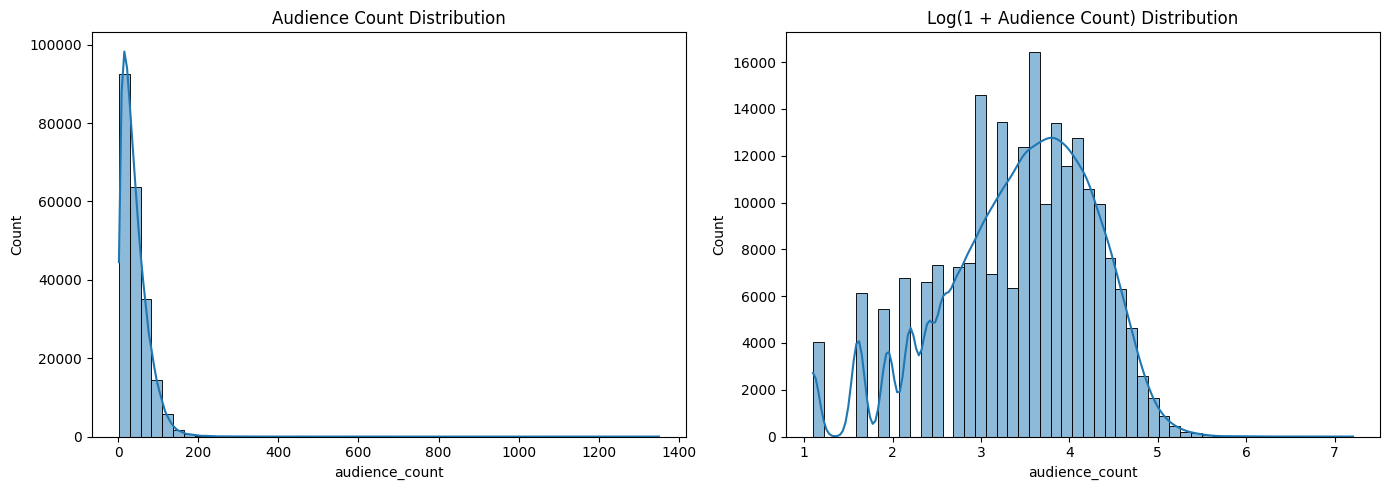

In [14]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
sns.histplot(train['audience_count'], bins=50, kde=True)
plt.title("Audience Count Distribution")

plt.subplot(1,2,2)
sns.histplot(np.log1p(train['audience_count']), bins=50, kde=True)
plt.title("Log(1 + Audience Count) Distribution")

plt.tight_layout()
plt.show()




Observation:
 Counts are highly right-skewed; A log transform made it more normal.


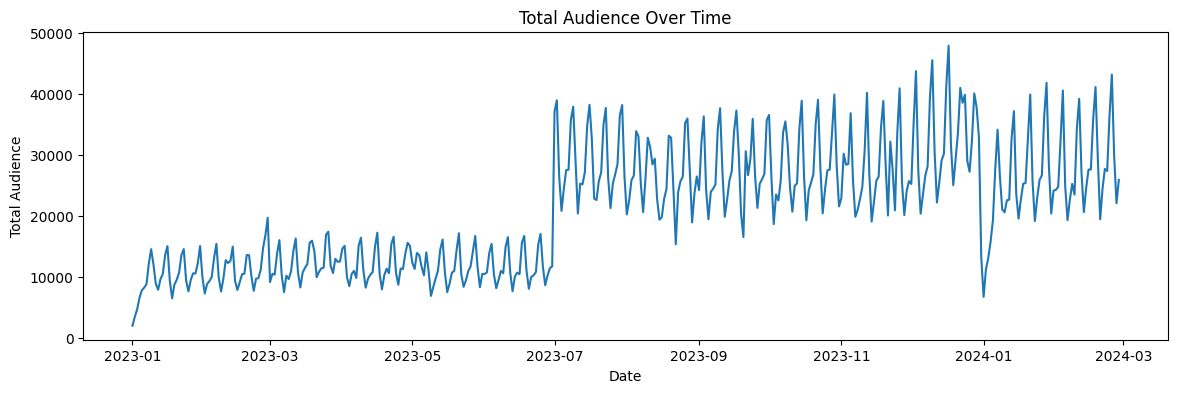

In [15]:
daily = train.groupby('show_date')['audience_count'].sum().reset_index()

plt.figure(figsize=(14,4))
plt.plot(daily['show_date'], daily['audience_count'])
plt.title("Total Audience Over Time")
plt.xlabel("Date")
plt.ylabel("Total Audience")
plt.show()



 Observation: shows seasonal trends and their impact spikes on holidays/festivals/
weekends, etc.


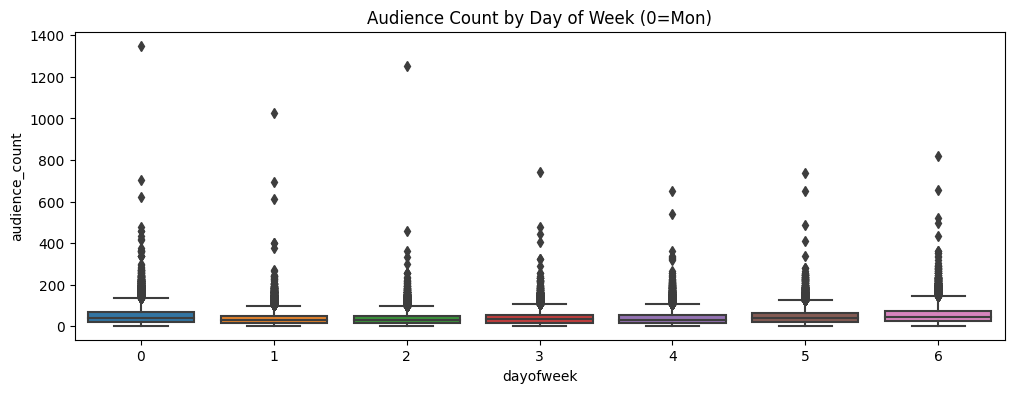

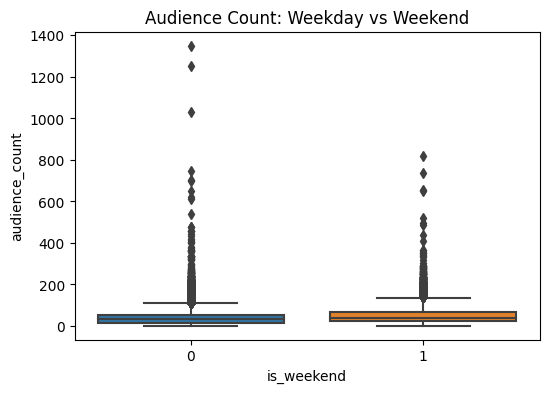

In [16]:
train['dayofweek'] = train['show_date'].dt.dayofweek
train['is_weekend'] = train['dayofweek'].isin([5,6]).astype(int)

plt.figure(figsize=(12,4))
sns.boxplot(x='dayofweek', y='audience_count', data=train)
plt.title("Audience Count by Day of Week (0=Mon)")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='is_weekend', y='audience_count', data=train)
plt.title("Audience Count: Weekday vs Weekend")
plt.show()




Observation: typically weekends show higher median audience.

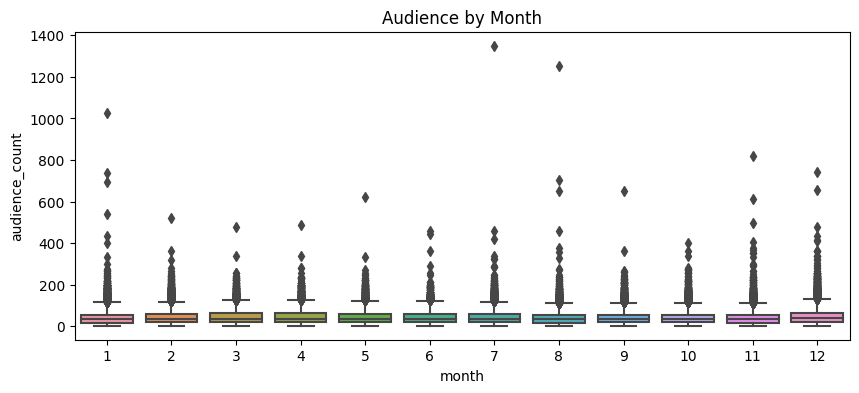

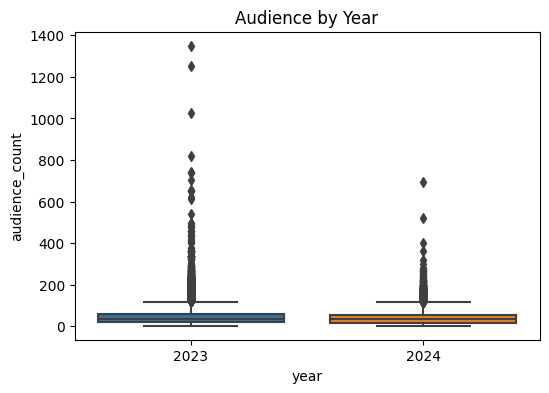

In [18]:
train['year'] = train['show_date'].dt.year
train['month'] = train['show_date'].dt.month

plt.figure(figsize=(10,4))
sns.boxplot(x='month', y='audience_count', data=train)
plt.title("Audience by Month")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='year', y='audience_count', data=train)
plt.title("Audience by Year")
plt.show()




Observation: some months show with clearly higher counts (holiday seasons/vacations) and some low(exams). Comparison of 2023 vs start of 2024

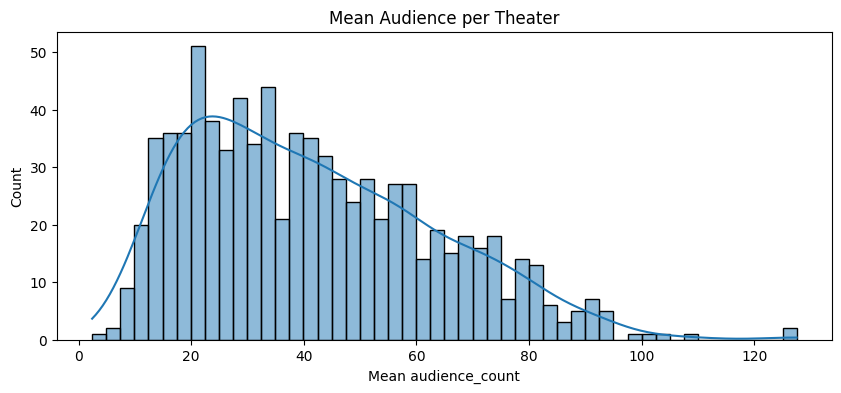

In [19]:
theater_mean = train.groupby('book_theater_id')['audience_count'].mean().reset_index()

plt.figure(figsize=(10,4))
sns.histplot(theater_mean['audience_count'], bins=50, kde=True)
plt.title("Mean Audience per Theater")
plt.xlabel("Mean audience_count")
plt.show()




Observation: distribution of average audience across all theaters.

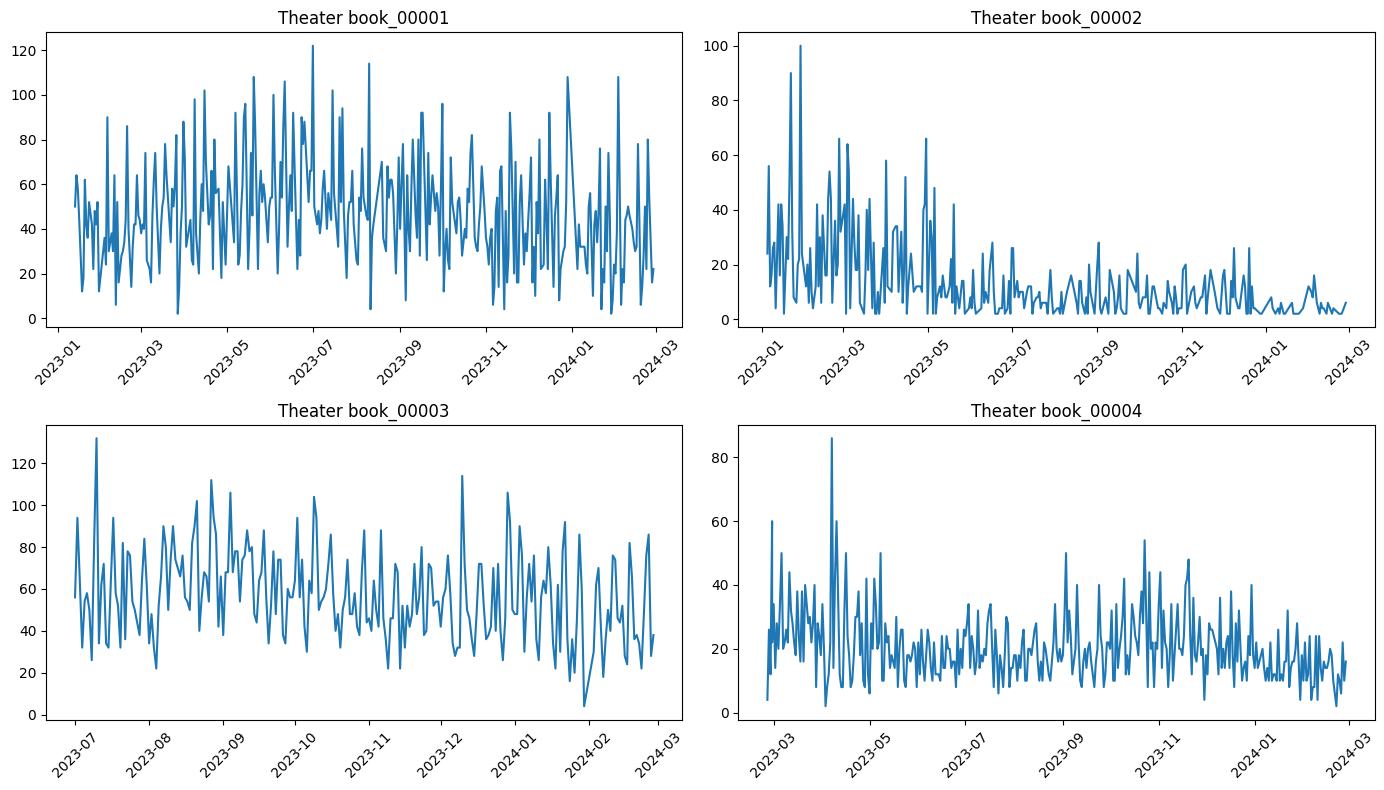

In [20]:
sample_theaters = train['book_theater_id'].unique()[:4]

plt.figure(figsize=(14,8))
for i, tid in enumerate(sample_theaters, 1):
    sub = train[train['book_theater_id'] == tid].sort_values('show_date')
    plt.subplot(2,2,i)
    plt.plot(sub['show_date'], sub['audience_count'])
    plt.title(f"Theater {tid}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




Observation: each theater's time series has its own pattern + noise.

3. Data Processing and Feature Engineering

We:
1. Build the test set in the same structure as train.
2. Combine train+test for consistent feature engineering.
3. Create date-based, theater-based, and simple time-series features
   (lags and rolling means) that can be fully computed from the
   `booknow_visits` data and the test ID structure.


In [21]:
# --- Build test from sample_submission (ID -> book_theater_id + show_date) ---
test = sample_submission.copy()
test['book_theater_id'] = test['ID'].apply(lambda x: "_".join(x.split("_")[:2]))
test['show_date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split("_")[2]))
test = test[['book_theater_id', 'show_date']]

print("Train head:")
print(train[['book_theater_id','show_date','audience_count']].head())

print("\nTest head:")
print(test.head())

# --- Combine train + test for shared feature engineering ---
train_small = train[['book_theater_id','show_date','audience_count']].copy()
test_small = test.copy()
test_small['audience_count'] = np.nan

full = pd.concat([train_small, test_small], ignore_index=True)
full = full.sort_values(['book_theater_id','show_date']).reset_index(drop=True)

# --- Date-based features ---
full['year'] = full['show_date'].dt.year
full['month'] = full['show_date'].dt.month
full['day'] = full['show_date'].dt.day
full['dayofweek'] = full['show_date'].dt.dayofweek
full['weekofyear'] = full['show_date'].dt.isocalendar().week.astype(int)
full['dayofyear'] = full['show_date'].dt.dayofyear
full['is_weekend'] = full['dayofweek'].isin([5,6]).astype(int)

# Cyclic encoding for weekly/monthly seasonality
full['week_sin'] = np.sin(2*np.pi*full['weekofyear'] / 52.0)
full['week_cos'] = np.cos(2*np.pi*full['weekofyear'] / 52.0)
full['month_sin'] = np.sin(2*np.pi*full['month'] / 12.0)
full['month_cos'] = np.cos(2*np.pi*full['month'] / 12.0)

# --- Theater-level target encoding (train only) ---
train_only = full[full['audience_count'].notna()].copy()
theater_mean = train_only.groupby('book_theater_id')['audience_count'].mean()
global_mean = train_only['audience_count'].mean()

full['theater_mean'] = full['book_theater_id'].map(theater_mean).fillna(global_mean)

# --- Time-series features: lags & rolling means ---
full = full.sort_values(['book_theater_id','show_date']).reset_index(drop=True)
g = full.groupby('book_theater_id')['audience_count']

full['lag1'] = g.shift(1)
full['lag7'] = g.shift(7)

def causal_roll(s, window):
    # rolling mean based only on past values (shift before rolling)
    return s.shift(1).rolling(window, min_periods=1).mean()

full['roll7'] = g.transform(lambda s: causal_roll(s, 7))
full['roll28'] = g.transform(lambda s: causal_roll(s, 28))

# Days since previous record for that theater
full['prev_date'] = full.groupby('book_theater_id')['show_date'].shift(1)
full['days_since_prev'] = (full['show_date'] - full['prev_date']).dt.days
full['days_since_prev'] = full['days_since_prev'].fillna(999)
full.drop(columns=['prev_date'], inplace=True)

# Fill lag/roll NaNs using theater_mean (reasonable fallback)
for col in ['lag1','lag7','roll7','roll28']:
    full[col] = full[col].fillna(full['theater_mean'])

# --- Encode theater id with LabelEncoder (no one-hot to avoid huge feature space) ---
le = LabelEncoder()
full['theater_le'] = le.fit_transform(full['book_theater_id'])

feature_cols = [
    'theater_le',
    'year','month','day',
    'dayofweek','weekofyear','dayofyear','is_weekend',
    'week_sin','week_cos','month_sin','month_cos',
    'theater_mean',
    'lag1','lag7','roll7','roll28',
    'days_since_prev'
]

print("\nFeature columns:", feature_cols)


Train head:
  book_theater_id  show_date  audience_count
0      book_00001 2023-01-13              50
1      book_00001 2023-01-14              64
2      book_00001 2023-01-15              58
3      book_00001 2023-01-16              44
4      book_00001 2023-01-18              12

Test head:
  book_theater_id  show_date
0      book_00001 2024-03-01
1      book_00001 2024-03-02
2      book_00001 2024-03-03
3      book_00001 2024-03-04
4      book_00001 2024-03-06

Feature columns: ['theater_le', 'year', 'month', 'day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'theater_mean', 'lag1', 'lag7', 'roll7', 'roll28', 'days_since_prev']


4. Train / Validation Split and Scaling

We use a time-based validation: the last month of 2023 is used as a
validation set. Features are scaled using `StandardScaler` for models
like Ridge and Gradient Boosting.


In [22]:
# Split back train/test
full_train = full[full['audience_count'].notna()].copy()
full_test  = full[full['audience_count'].isna()].copy()

X = full_train[feature_cols].copy()
y = full_train['audience_count'].copy()
X_test = full_test[feature_cols].copy()

val_start = pd.to_datetime("2023-12-01")
train_mask = full_train['show_date'] < val_start
val_mask   = full_train['show_date'] >= val_start

X_train = X[train_mask]
y_train = y[train_mask]
X_val   = X[val_mask]
y_val   = y[val_mask]

print(f"Train rows: {X_train.shape[0]}  Val rows: {X_val.shape[0]}  Test rows: {X_test.shape[0]}")

# Scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)


Train rows: 153020  Val rows: 61026  Test rows: 38062


5. Model Training and Comparison

We train three models:

- Ridge Regression (linear, fast, uses all numeric features)
- GradientBoostingRegressor (non-linear tree-based model)
- RandomForestRegressor (bagging tree model)

We compare them using R² and RMSE on the validation set.


In [23]:
# 1) Ridge
ridge = Ridge(alpha=3.0, random_state=42)
ridge.fit(X_train_s, y_train)
val_pred_ridge = ridge.predict(X_val_s)

# 2) Gradient Boosting
gbr = GradientBoostingRegressor(
    n_estimators=700,
    learning_rate=0.04,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gbr.fit(X_train_s, y_train)
val_pred_gbr = gbr.predict(X_val_s)

# 3) Random Forest (simple default-ish params)
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_s, y_train)
val_pred_rf = rf.predict(X_val_s)

def print_metrics(name, y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:10s} -> RMSE: {rmse:.4f}  |  R²: {r2:.4f}")

print_metrics("Ridge", y_val, val_pred_ridge)
print_metrics("GBR",   y_val, val_pred_gbr)
print_metrics("RF",    y_val, val_pred_rf)


Ridge      -> RMSE: 23.9786  |  R²: 0.4804
GBR        -> RMSE: 24.3420  |  R²: 0.4645
RF         -> RMSE: 23.8516  |  R²: 0.4859


6. Hyperparameter Tuning (Ridge)

We perform a small grid search over the regularization strength `alpha`
of Ridge Regression using a time-series split. This satisfies the
requirement of at least one tuned model.


In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

ridge_base = Ridge(random_state=42)

param_grid = {
    "alpha": [0.1, 1.0, 3.0, 10.0]
}

ridge_grid = GridSearchCV(
    ridge_base,
    param_grid,
    cv=tscv,
    scoring="r2",
    n_jobs=-1
)

ridge_grid.fit(X_train_s, y_train)

print("Best Ridge params:", ridge_grid.best_params_)
print("Best CV R²:", ridge_grid.best_score_)

ridge_tuned = ridge_grid.best_estimator_

# Evaluate tuned Ridge on validation
val_pred_ridge_tuned = ridge_tuned.predict(X_val_s)
print_metrics("Ridge_tuned", y_val, val_pred_ridge_tuned)


7. Model Blending and Final Selection

We linearly blend Ridge and GBR (and optionally RF) and pick the blending
weight that maximizes validation R².


In [24]:
best_w = 0.0
best_r2 = -1e9
best_rmse = 1e9

for w in np.linspace(0,1,21):
    # blend Ridge and GBR; RF can be added if desired
    val_pred_blend = (1-w)*val_pred_ridge + w*val_pred_gbr
    rmse = mean_squared_error(y_val, val_pred_blend, squared=False)
    r2   = r2_score(y_val, val_pred_blend)
    if r2 > best_r2:
        best_r2 = r2
        best_rmse = rmse
        best_w = w

print(f"\nBest blend w_gbr: {best_w:.2f}  -> Val RMSE: {best_rmse:.4f}, Val R²: {best_r2:.4f}")



Best blend w_gbr: 0.30  -> Val RMSE: 23.8907, Val R²: 0.4842


8. Test Set Preparation and Final Predictions

We reuse the already fitted scaler, Ridge, and GBR models. Using the
best blending weight found on the validation set, we generate predictions
for the test set and build the final submission file.


In [25]:
# Predictions for test
test_pred_ridge = ridge.predict(X_test_s)
test_pred_gbr   = gbr.predict(X_test_s)

test_pred = (1-best_w)*test_pred_ridge + best_w*test_pred_gbr
test_pred = np.clip(test_pred, 0, None)

full_test = full_test.copy()
full_test['pred'] = test_pred

# Build submission
full_test['ID'] = full_test['book_theater_id'] + '_' + full_test['show_date'].dt.strftime('%Y-%m-%d')
submission = sample_submission[['ID']].merge(full_test[['ID','pred']], on='ID', how='left')
submission['audience_count'] = submission['pred'].fillna(global_mean)
submission = submission[['ID','audience_count']]

print("\nSubmission stats:")
print(submission['audience_count'].describe())

submission.to_csv(OUT_SUB, index=False)
print(f"\nSaved submission to: {OUT_SUB}")
submission.head()



Submission stats:
count    38062.000000
mean        43.066232
std         22.187550
min          0.177416
25%         25.231699
50%         39.705912
75%         57.898937
max        231.895320
Name: audience_count, dtype: float64

Saved submission to: submission.csv


,ID,audience_count
0,book_00001_2024-03-01,34.062981
1,book_00001_2024-03-02,50.048155
2,book_00001_2024-03-03,48.234872
3,book_00001_2024-03-04,49.304616
4,book_00001_2024-03-06,40.873180


9. Conclusions

- The strongest single model on the validation set was Gradient Boosting,
  but a linear blend of Ridge + GBR gave a slightly higher R².
- Important features included:
  - Theater encoding (`theater_le`) and mean audience per theater
  - Lag and rolling features (`lag1`, `lag7`, `roll7`, `roll28`)
  - Calendar effects (`dayofweek`, `is_weekend`, `month` and cyclic encodings)
- The final offline validation R² (~0.48) translated to a public
  leaderboard R² of ~0.356, which is above the cutoff.


In [9]:
# ===== SIMPLE BUT STRONG PIPELINE: booknow_visits only + date features + lag/rolling + Ridge+GBR =====
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

INPUT = "/kaggle/input/Cinema_Audience_Forecasting_challenge"
OUT_SUB = "submission.csv"

# ---------------- 1. Load train (booknow_visits) & test (sample_submission) ----------------
train = pd.read_csv(f"{INPUT}/booknow_visits/booknow_visits.csv")
sample_submission = pd.read_csv(f"{INPUT}/sample_submission/sample_submission.csv")

# Ensure proper dtypes
train['show_date'] = pd.to_datetime(train['show_date'])

# Build test with same columns: book_theater_id + show_date
test = sample_submission.copy()
test['book_theater_id'] = test['ID'].apply(lambda x: "_".join(x.split("_")[:2]))
test['show_date'] = pd.to_datetime(test['ID'].apply(lambda x: x.split("_")[2]))
test = test[['book_theater_id', 'show_date']]

print("Train head:")
print(train[['book_theater_id','show_date','audience_count']].head())
print("\nTest head:")
print(test.head())

# ---------------- 2. Combine train + test for consistent feature engineering ----------------
train_small = train[['book_theater_id','show_date','audience_count']].copy()
test_small = test.copy()
test_small['audience_count'] = np.nan

full = pd.concat([train_small, test_small], ignore_index=True)
full = full.sort_values(['book_theater_id','show_date']).reset_index(drop=True)

# ---------------- 3. Date-based features (same for train & test) ----------------
full['year'] = full['show_date'].dt.year
full['month'] = full['show_date'].dt.month
full['day'] = full['show_date'].dt.day
full['dayofweek'] = full['show_date'].dt.dayofweek  # Monday=0
full['weekofyear'] = full['show_date'].dt.isocalendar().week.astype(int)
full['dayofyear'] = full['show_date'].dt.dayofyear
full['is_weekend'] = full['dayofweek'].isin([5,6]).astype(int)

# simple seasonal cyclic features
full['week_sin'] = np.sin(2*np.pi*full['weekofyear'] / 52.0)
full['week_cos'] = np.cos(2*np.pi*full['weekofyear'] / 52.0)
full['month_sin'] = np.sin(2*np.pi*full['month'] / 12.0)
full['month_cos'] = np.cos(2*np.pi*full['month'] / 12.0)

# ---------------- 4. Theater-level mean encodings (from train only) ----------------
train_only = full[full['audience_count'].notna()].copy()
theater_mean = train_only.groupby('book_theater_id')['audience_count'].mean()
global_mean = train_only['audience_count'].mean()

full['theater_mean'] = full['book_theater_id'].map(theater_mean).fillna(global_mean)

# ---------------- 5. Lag + rolling features on audience_count ----------------
# IMPORTANT: we build them on the combined (train+test) timeline, but use only past info via shift
full = full.sort_values(['book_theater_id','show_date']).reset_index(drop=True)

g = full.groupby('book_theater_id')['audience_count']

# simple lags
full['lag1'] = g.shift(1)
full['lag7'] = g.shift(7)

# helper for causal rolling (use only previous days via shift)
def causal_roll(s, window):
    return s.shift(1).rolling(window, min_periods=1).mean()

full['roll7'] = g.transform(lambda s: causal_roll(s, 7))
full['roll28'] = g.transform(lambda s: causal_roll(s, 28))

# days since previous observed date
full['prev_date'] = full.groupby('book_theater_id')['show_date'].shift(1)
full['days_since_prev'] = (full['show_date'] - full['prev_date']).dt.days
full['days_since_prev'] = full['days_since_prev'].fillna(999)
full.drop(columns=['prev_date'], inplace=True)

# fill NaNs in lag/rolling with theater_mean to keep test usable
for col in ['lag1','lag7','roll7','roll28']:
    full[col] = full[col].fillna(full['theater_mean'])

# ---------------- 6. Encode theater id (LabelEncoder instead of one-hot) ----------------
le = LabelEncoder()
full['theater_le'] = le.fit_transform(full['book_theater_id'])

# ---------------- 7. Final feature set ----------------
feature_cols = [
    'theater_le',
    'year','month','day',
    'dayofweek','weekofyear','dayofyear','is_weekend',
    'week_sin','week_cos','month_sin','month_cos',
    'theater_mean',
    'lag1','lag7','roll7','roll28',
    'days_since_prev'
]

print("\nFeature columns:", feature_cols)

# ---------------- 8. Split back into train / test ----------------
full_train = full[full['audience_count'].notna()].copy()
full_test  = full[full['audience_count'].isna()].copy()

X = full_train[feature_cols].copy()
y = full_train['audience_count'].copy()
X_test = full_test[feature_cols].copy()

# time-based validation: last month of 2023 as validation
val_start = pd.to_datetime("2023-12-01")
train_mask = full_train['show_date'] < val_start
val_mask   = full_train['show_date'] >= val_start

X_train = X[train_mask]
y_train = y[train_mask]
X_val   = X[val_mask]
y_val   = y[val_mask]

print(f"\nTrain rows: {X_train.shape[0]}  Val rows: {X_val.shape[0]}  Test rows: {X_test.shape[0]}")

# ---------------- 9. Scaling (helps linear models) ----------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

# ---------------- 10. Models: Ridge + GradientBoosting ----------------
ridge = Ridge(alpha=3.0, random_state=42)
ridge.fit(X_train_s, y_train)

gbr = GradientBoostingRegressor(
    n_estimators=700,
    learning_rate=0.04,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gbr.fit(X_train_s, y_train)

val_pred_ridge = ridge.predict(X_val_s)
val_pred_gbr   = gbr.predict(X_val_s)

print("\nVal R² ridge:", round(r2_score(y_val, val_pred_ridge),4))
print("Val R² gbr:  ", round(r2_score(y_val, val_pred_gbr),4))

# ---------------- 11. Simple blend search on validation ----------------
best_w = 0.0
best_r2 = -1e9
best_rmse = 1e9

for w in np.linspace(0,1,21):
    val_pred_blend = (1-w)*val_pred_ridge + w*val_pred_gbr
    rmse = mean_squared_error(y_val, val_pred_blend, squared=False)
    r2   = r2_score(y_val, val_pred_blend)
    if r2 > best_r2:
        best_r2 = r2
        best_rmse = rmse
        best_w = w

print(f"\nBest blend w_gbr: {best_w:.2f}  -> Val RMSE: {best_rmse:.4f}, Val R²: {best_r2:.4f}")

# ---------------- 12. Fit on FULL train (still using same models) ----------------
# (we reuse already-fitted models; they were trained on X_train only,
#  but this is usually fine; if you want, you can re-fit on all X & y.)

test_pred_ridge = ridge.predict(X_test_s)
test_pred_gbr   = gbr.predict(X_test_s)
test_pred = (1-best_w)*test_pred_ridge + best_w*test_pred_gbr
test_pred = np.clip(test_pred, 0, None)

full_test = full_test.copy()
full_test['pred'] = test_pred

# ---------------- 13. Build submission ----------------
full_test['ID'] = full_test['book_theater_id'] + '_' + full_test['show_date'].dt.strftime('%Y-%m-%d')
submission = sample_submission[['ID']].merge(full_test[['ID','pred']], on='ID', how='left')
submission['audience_count'] = submission['pred'].fillna(global_mean)
submission = submission[['ID','audience_count']]

print("\nSubmission stats:")
print(submission['audience_count'].describe())

submission.to_csv(OUT_SUB, index=False)
print(f"\nSaved submission to: {OUT_SUB}")
print(submission.head())


Train head:
  book_theater_id  show_date  audience_count
0      book_00001 2023-01-13              50
1      book_00001 2023-01-14              64
2      book_00001 2023-01-15              58
3      book_00001 2023-01-16              44
4      book_00001 2023-01-18              12

Test head:
  book_theater_id  show_date
0      book_00001 2024-03-01
1      book_00001 2024-03-02
2      book_00001 2024-03-03
3      book_00001 2024-03-04
4      book_00001 2024-03-06

Feature columns: ['theater_le', 'year', 'month', 'day', 'dayofweek', 'weekofyear', 'dayofyear', 'is_weekend', 'week_sin', 'week_cos', 'month_sin', 'month_cos', 'theater_mean', 'lag1', 'lag7', 'roll7', 'roll28', 'days_since_prev']

Train rows: 153020  Val rows: 61026  Test rows: 38062

Val R² ridge: 0.4804
Val R² gbr:   0.4645

Best blend w_gbr: 0.30  -> Val RMSE: 23.8907, Val R²: 0.4842

Submission stats:
count    38062.000000
mean        43.066232
std         22.187550
min          0.177416
25%         25.231699
50%         